In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from batch_process import BatchProcess, FedBatchProcess
from pinn import PINN, numpy_to_tensor, train
from utils import get_data

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

# # Define kinetic parameters
# spyros_mu_max = 0.870
# spyros_K_s = 0.214
# spyros_Y_xs = 0.496

__Functions__

In [21]:
def plot_simulation(t, y, full_df, train_df, net_df, i, mu_max, Ks, Yxs):
    plt.figure(figsize=(10, 5))
    plt.rc('font', size=10)
    plt.rcParams['legend.handlelength'] = 1
    plt.plot(t, y[0], label='Biomass (ODE)', alpha=0.3)
    plt.plot(t, y[1], label='Glucose (ODE)', alpha=0.3)
    plt.scatter(full_df['RTime'], full_df['Glucose'], s=10, label='Glucose (All)', color='red', alpha=0.2)   
    plt.scatter(full_df['RTime'], full_df['Biomass'], s=10, label='Biomass (All)', color='green', alpha=0.2)
    plt.scatter(train_df['RTime'], train_df['Glucose'], s=10, label='Glucose (Train)', color='red', alpha=1)   
    plt.scatter(train_df['RTime'], train_df['Biomass'], s=10, label='Biomass (Train)', color='green', alpha=1)
    plt.scatter(net_df['RTime'], net_df['Glucose'], marker='x', label='Glucose (Predicted)', color='red', s=10, alpha=0.5)
    plt.scatter(net_df['RTime'], net_df['Biomass'], marker='x', label='Biomass (Predicted)', color='green', s=10, alpha=0.5)
    plt.legend()
    plt.title(f'mu_max={mu_max:.4f}, Ks={Ks:.4f}, Yxs={Yxs:.4f}')
    plt.savefig(f'./plots/simulation_{i}.png')

def plot_data(df: pd.DataFrame):
    plt.figure(figsize=(10, 3))
    plt.scatter(df['RTime'], df['Glucose'], label='Glucose', color='red', alpha=0.5)
    plt.scatter(df['RTime'], df['Biomass'], label='Biomass', color='green', alpha=0.5)
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/L)')
    plt.legend()
    plt.show()

def simulate(df, mu_max, Ks, Yxs):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    
    def system_ode(t, y):
        X, S = y
        mu = mu_max * S / (Ks + S)
        dXdt = mu * X
        dSdt = - mu * X / Yxs
        return [dXdt, dSdt]
    
    t_eval = np.linspace(df['RTime'].min(), df['RTime'].max(), 10000)
    sol = solve_ivp(system_ode, [df['RTime'].min(), df['RTime'].max()], \
        [df['Biomass'].iloc[0], df['Glucose'].iloc[0]], t_eval=t_eval)
    return sol


def fit_polynomial(df: pd.DataFrame, column: str, degree: int = 3, num_points: int = 50):
    t_train = df['RTime'].values
    y_train = df[column].values

    poly = PolynomialFeatures(degree=degree)
    t_train = poly.fit_transform(t_train.reshape(-1, 1))
    poly.fit(t_train, y_train)
    lin_reg = LinearRegression()
    lin_reg.fit(t_train, y_train)
    
    t_simul = np.linspace(df['RTime'].min(), df['RTime'].max(), num_points)
    t_simul_poly = poly.fit_transform(t_simul.reshape(-1, 1))
    y_simul = lin_reg.predict(t_simul_poly)
    return t_simul, y_simul

__Data loading__

Dataset shape: (8, 8)


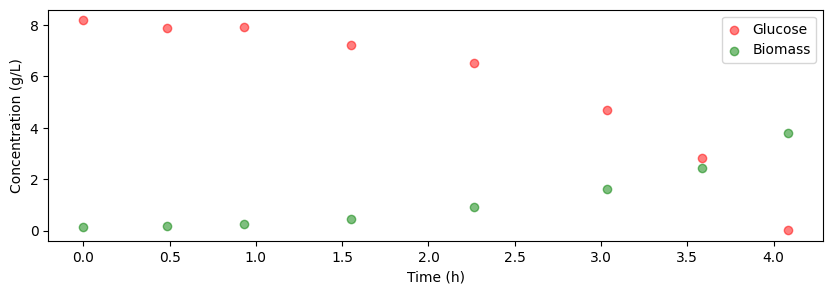

In [13]:
data = get_data(file_name='./Data_processed.xlsx')
exp = data.index.unique()

df = data.loc['BR01']
df = df[df['Process']=='B']
print(f'Dataset shape: {df.shape}')

plot_data(df)

__Data augmentation - In-silico data__

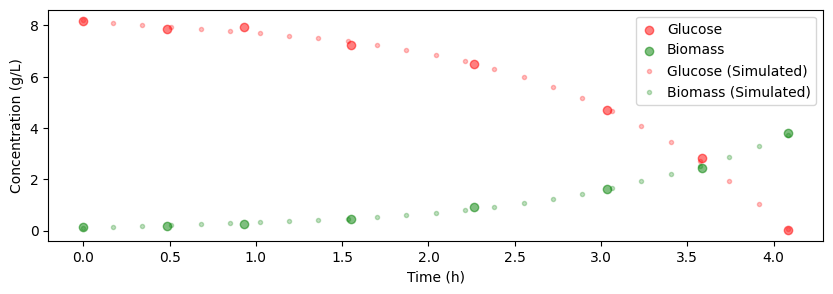

In [14]:
t_simul, biomass_simul = fit_polynomial(df, 'Biomass', degree=3, num_points=25)
_, glucose_simul = fit_polynomial(df, 'Glucose', degree=3, num_points=25)

# # Add gaussian noise
# biomass_simul += np.random.normal(0, 0.05, biomass_simul.shape)
# glucose_simul += np.random.normal(0, 0.05, glucose_simul.shape)

plt.figure(figsize=(10, 3))
plt.scatter(df['RTime'], df['Glucose'], label='Glucose', color='red', alpha=0.5)
plt.scatter(df['RTime'], df['Biomass'], label='Biomass', color='green', alpha=0.5)
plt.scatter(t_simul, glucose_simul, label='Glucose (Simulated)', marker='.', alpha=0.25, color='red')
plt.scatter(t_simul, biomass_simul, label='Biomass (Simulated)', marker='.', alpha=0.25, color='green')  
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.show()

In [15]:
# Concat df and simulated data
df_simul = pd.DataFrame({'RTime': t_simul, 'Biomass': biomass_simul, 'Glucose': glucose_simul})
df_simul['Process'] = 'B'
df_simul['Exp'] = 'BR01'
df_simul['Run'] = 0
df_simul['Type'] = 'Simulated'
df = pd.concat([df, df_simul])
df.sort_values('RTime', inplace=True)
df = df[['RTime', 'Glucose', 'Biomass']]
df = df[~df['RTime'].duplicated()]

Training using 2 data points
Epoch 0 || Total Loss: 70.782089
mu_max: 0.478158, Ks: 0.513424, Yxs: 0.5195
Training using 3 data points
Epoch 0 || Total Loss: 64.715363
mu_max: 0.464273, Ks: 0.533498, Yxs: 0.5359
Training using 4 data points
Epoch 0 || Total Loss: 66.412613
mu_max: 0.470514, Ks: 0.525772, Yxs: 0.5288
Training using 5 data points
Epoch 0 || Total Loss: 64.908813
mu_max: 0.460680, Ks: 0.536925, Yxs: 0.5391
Training using 6 data points
Epoch 0 || Total Loss: 63.478413
mu_max: 0.471688, Ks: 0.525447, Yxs: 0.4741
Training using 7 data points
Epoch 0 || Total Loss: 68.880470
mu_max: 0.483516, Ks: 0.508777, Yxs: 0.5162
Training using 8 data points
Epoch 0 || Total Loss: 64.487640
mu_max: 0.460184, Ks: 0.538257, Yxs: 0.5289
Training using 9 data points
Epoch 0 || Total Loss: 67.745049
mu_max: 0.490803, Ks: 0.506508, Yxs: 0.4917
Training using 10 data points
Epoch 0 || Total Loss: 64.239449
mu_max: 0.490773, Ks: 0.508721, Yxs: 0.4860
Training using 11 data points
Epoch 0 || Tota

/tmp/ipykernel_2635470/2942067028.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Training using 23 data points
Epoch 0 || Total Loss: 62.090572
mu_max: 0.472422, Ks: 0.519707, Yxs: 0.5267
Training using 24 data points
Epoch 0 || Total Loss: 57.291290
mu_max: 0.476636, Ks: 0.518946, Yxs: 0.5228
Training using 25 data points
Epoch 0 || Total Loss: 55.814266
mu_max: 0.493072, Ks: 0.506919, Yxs: 0.5012
Training using 26 data points
Epoch 0 || Total Loss: 58.275665
mu_max: 0.467503, Ks: 0.528903, Yxs: 0.5317
Training using 27 data points
Epoch 0 || Total Loss: 60.927193
mu_max: 0.493338, Ks: 0.505307, Yxs: 0.5067
Training using 28 data points
Epoch 0 || Total Loss: 55.109268
mu_max: 0.470741, Ks: 0.525372, Yxs: 0.5296
Training using 29 data points
Epoch 0 || Total Loss: 52.633945
mu_max: 0.459319, Ks: 0.538721, Yxs: 0.5393
Training using 30 data points
Epoch 0 || Total Loss: 56.769917
mu_max: 0.490936, Ks: 0.510178, Yxs: 0.5053
Training using 31 data points
Epoch 0 || Total Loss: 55.889519
mu_max: 0.466359, Ks: 0.527940, Yxs: 0.5159


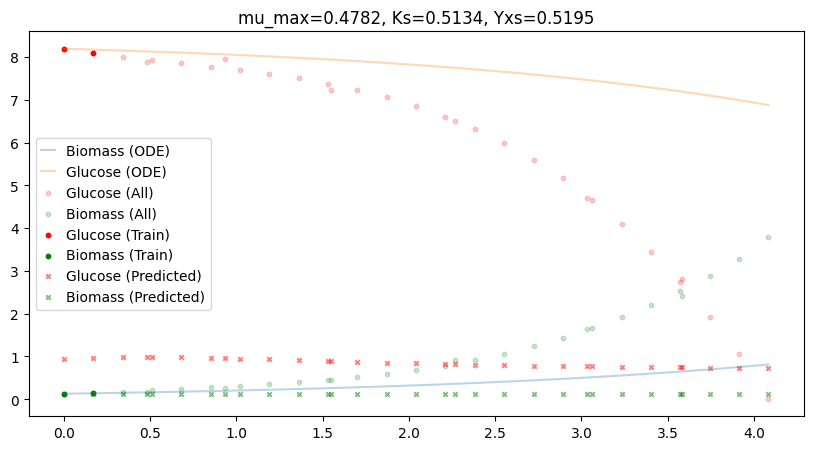

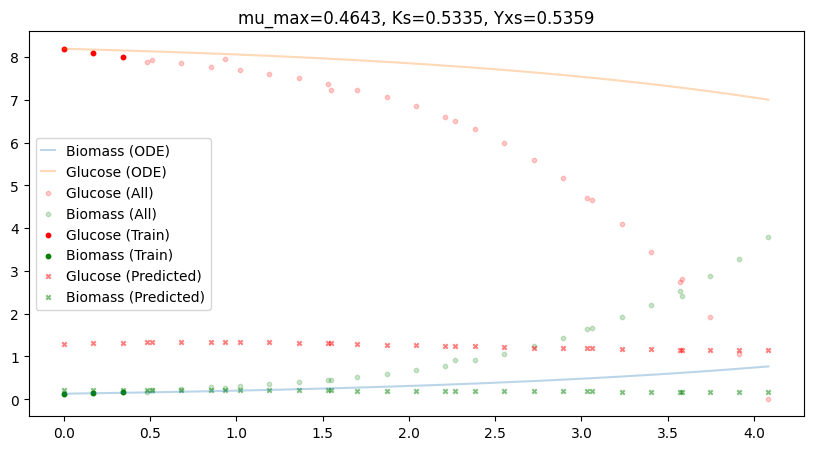

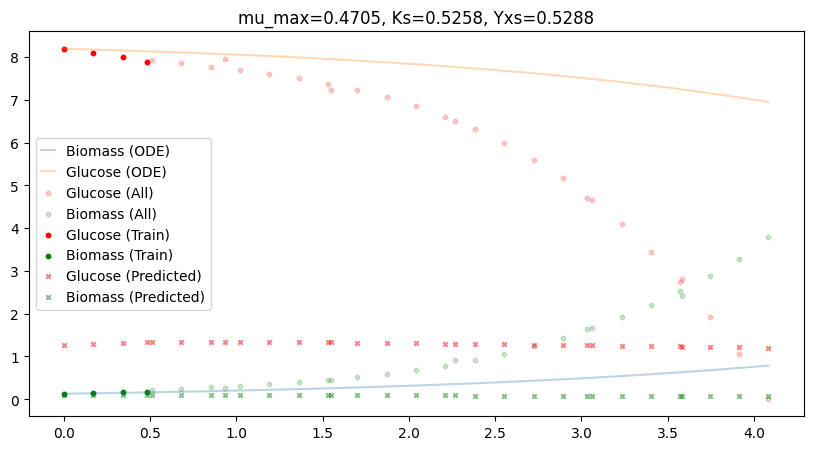

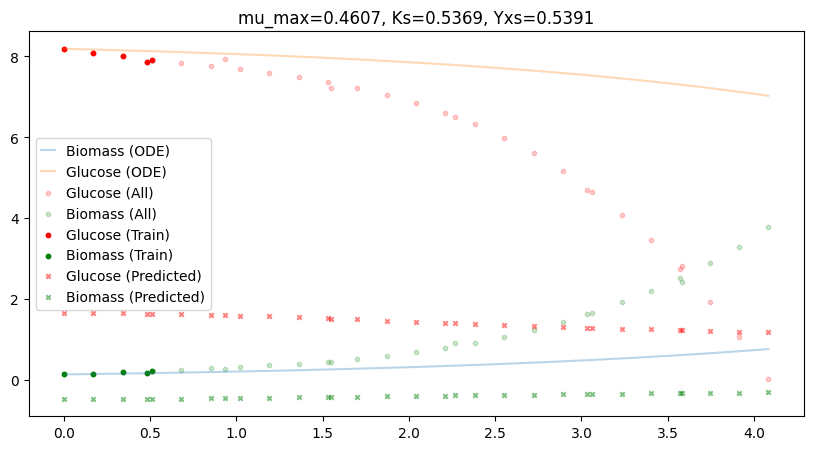

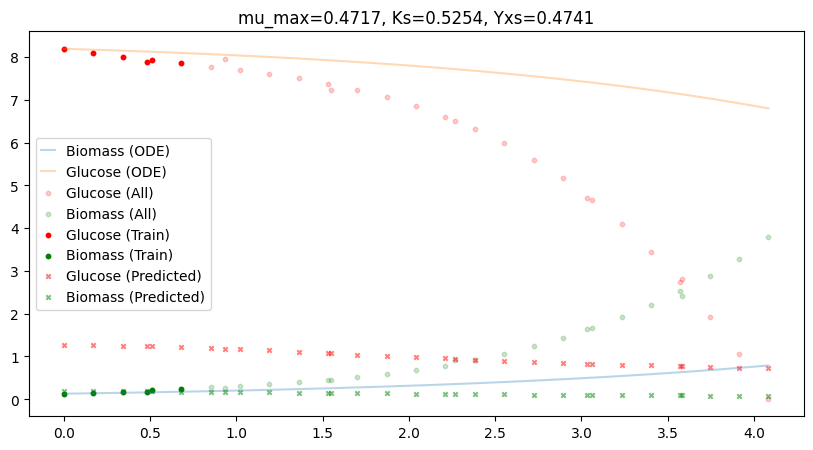

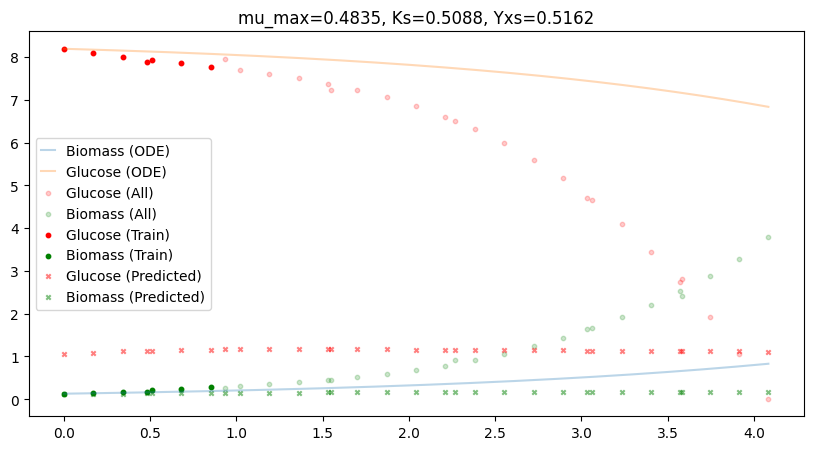

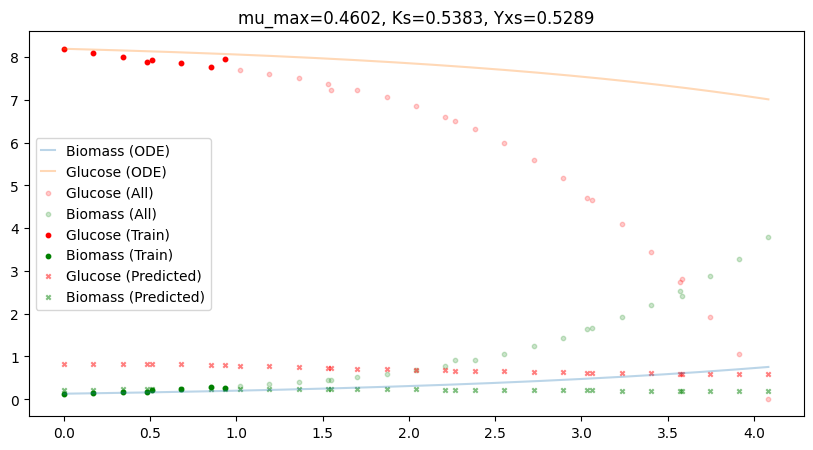

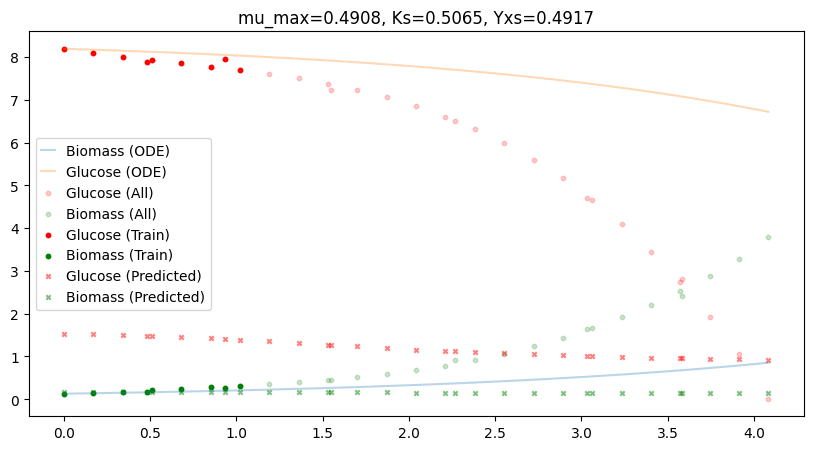

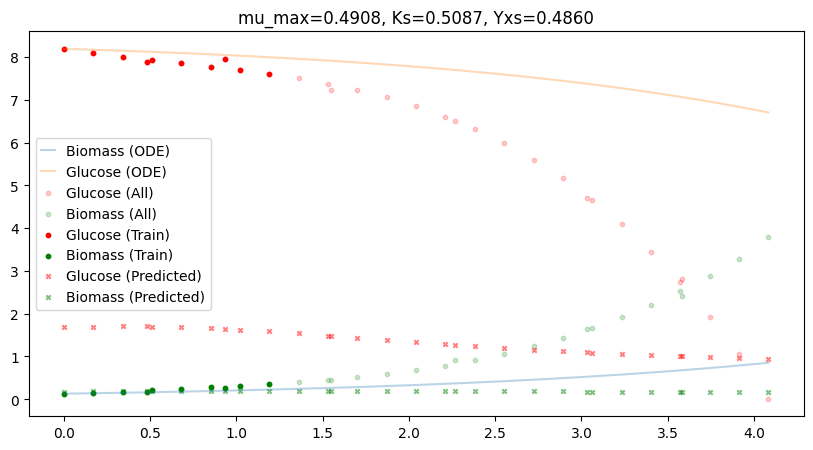

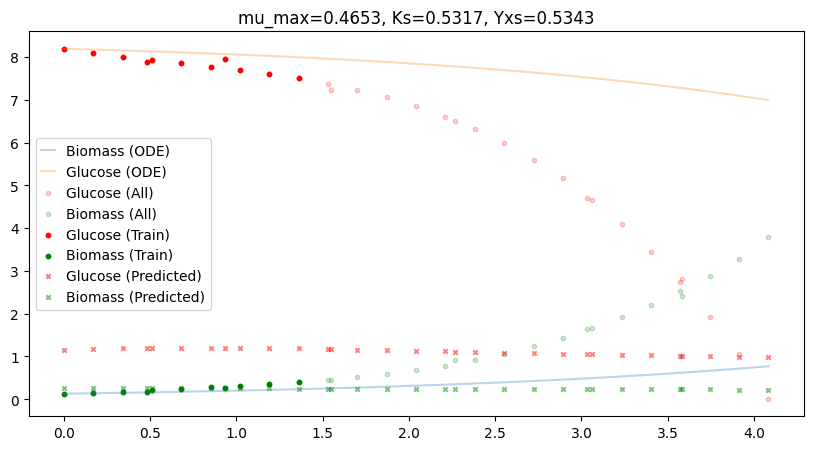

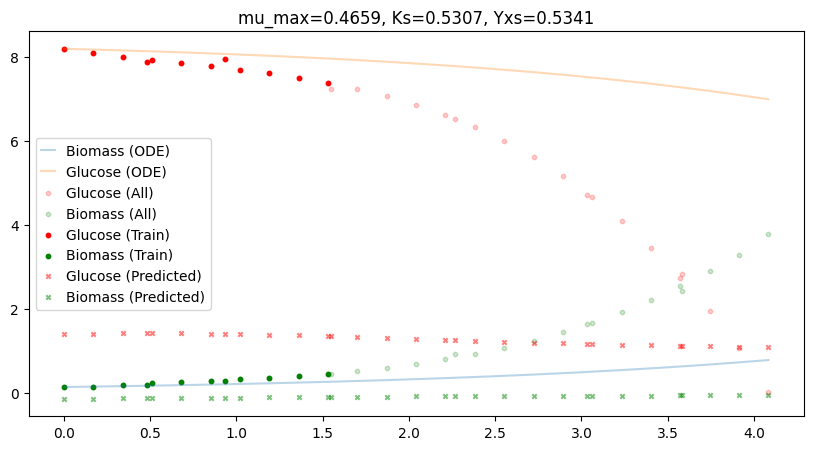

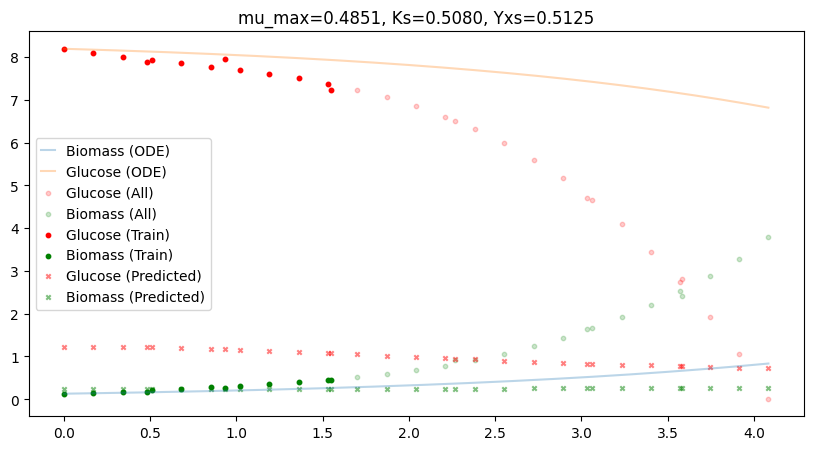

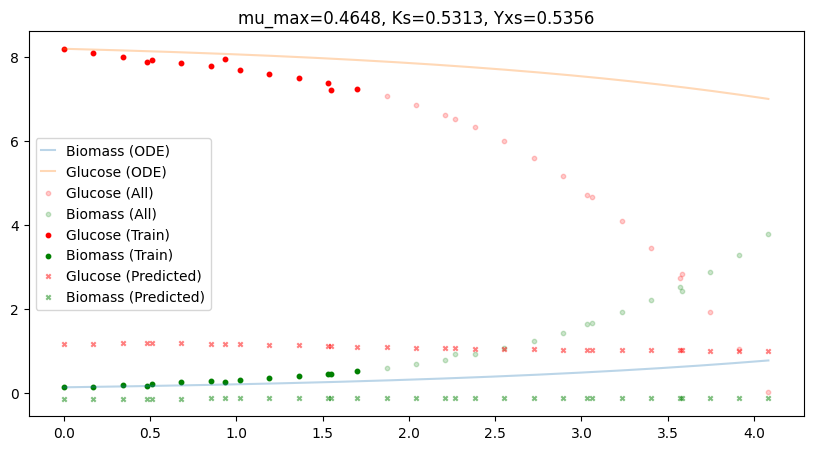

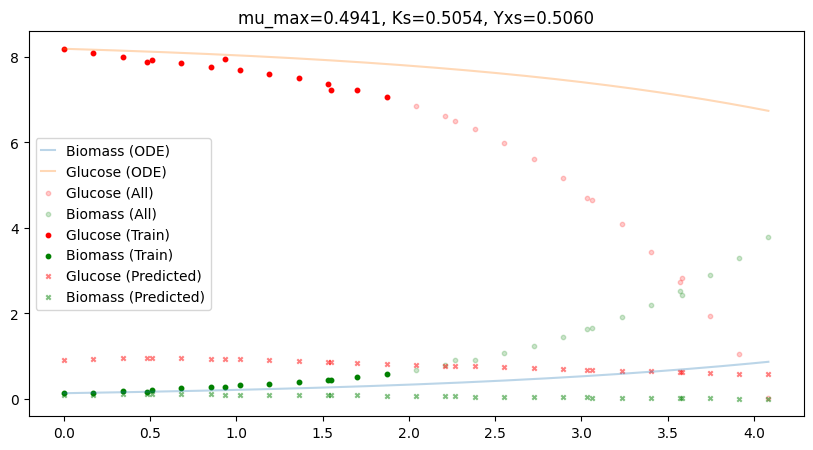

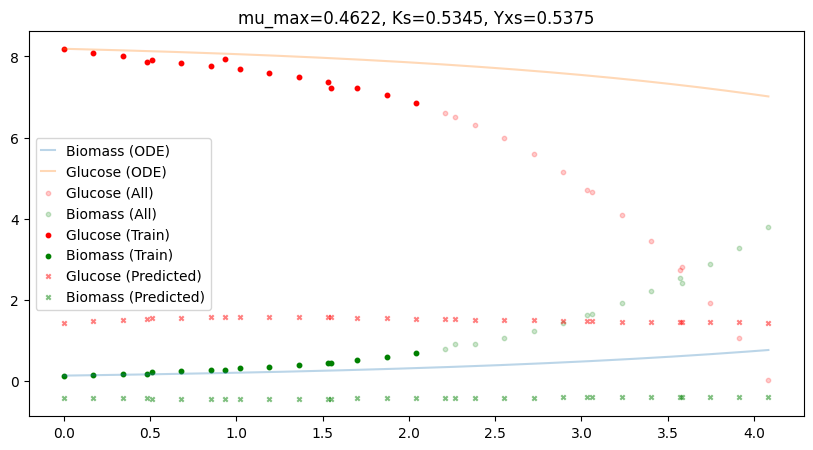

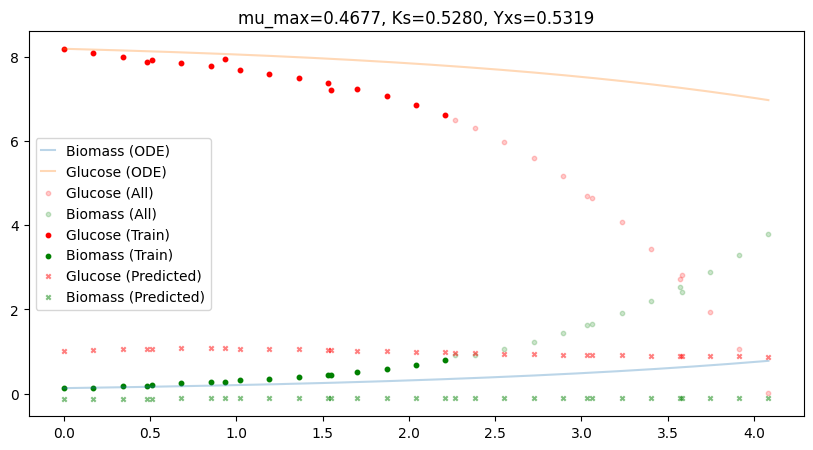

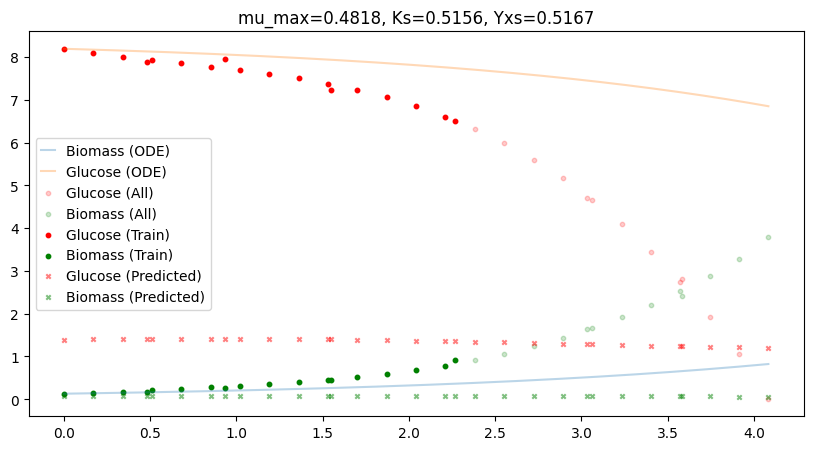

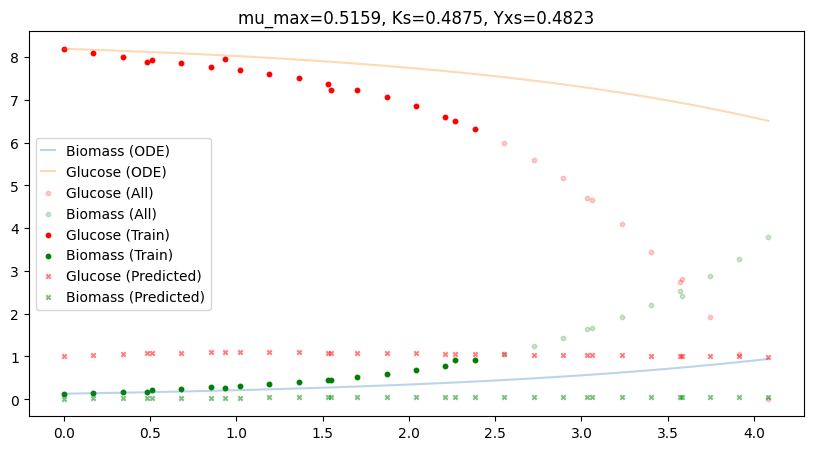

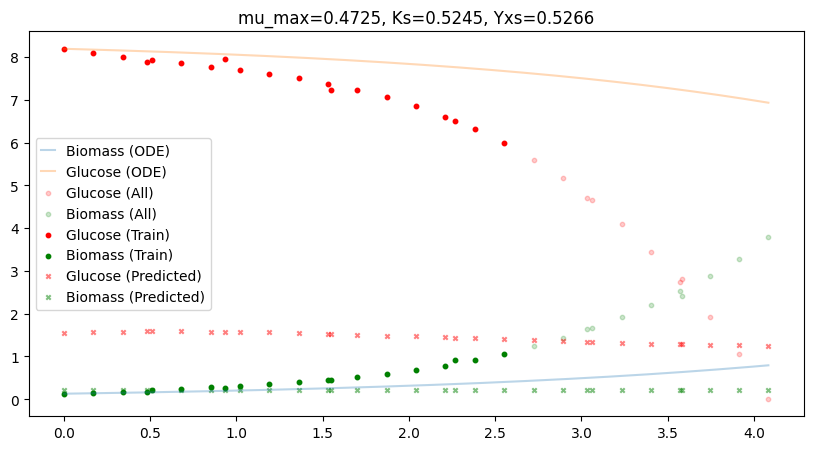

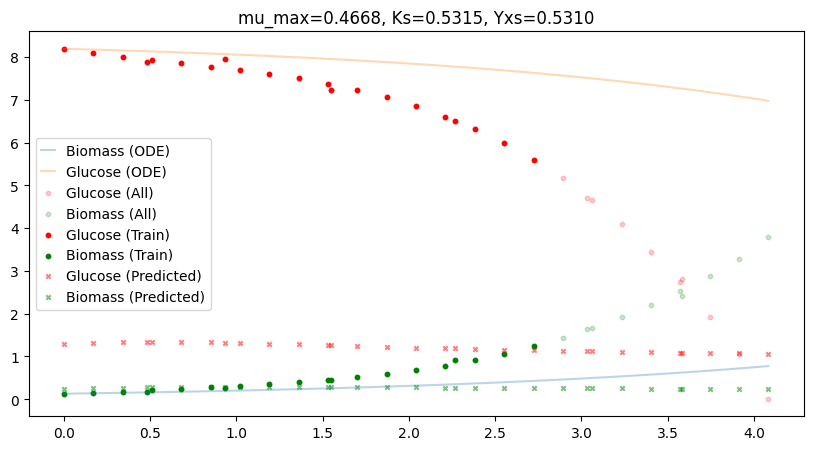

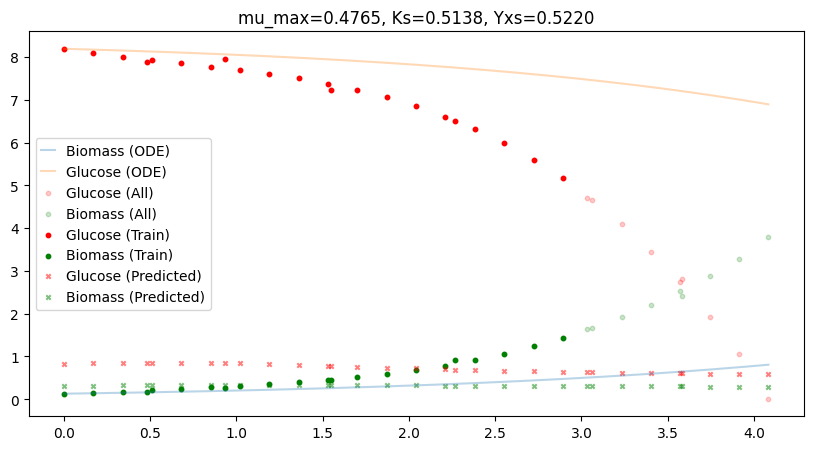

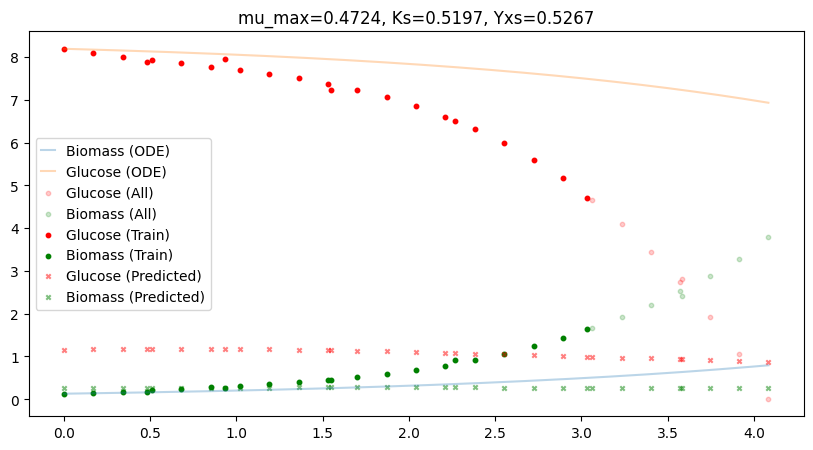

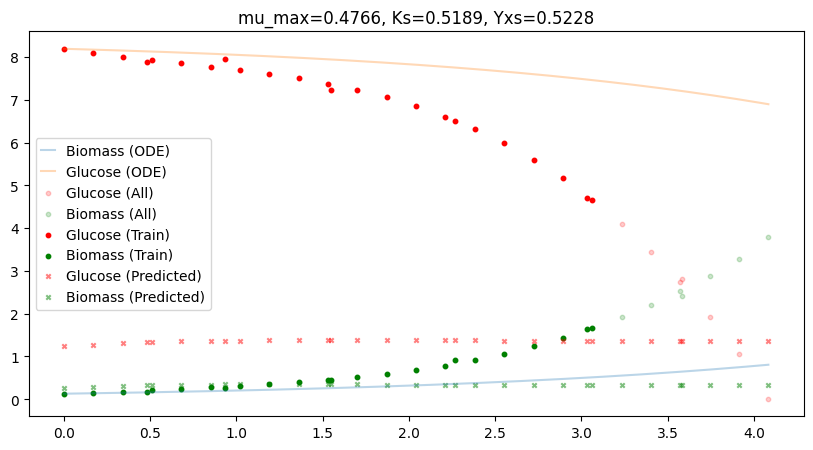

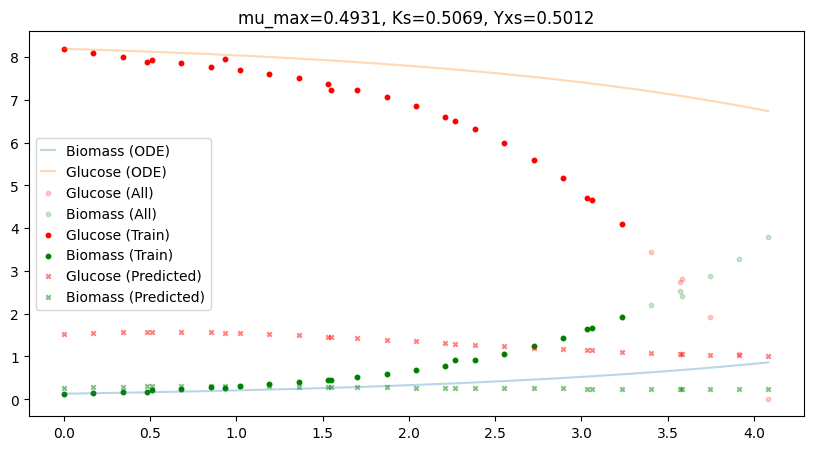

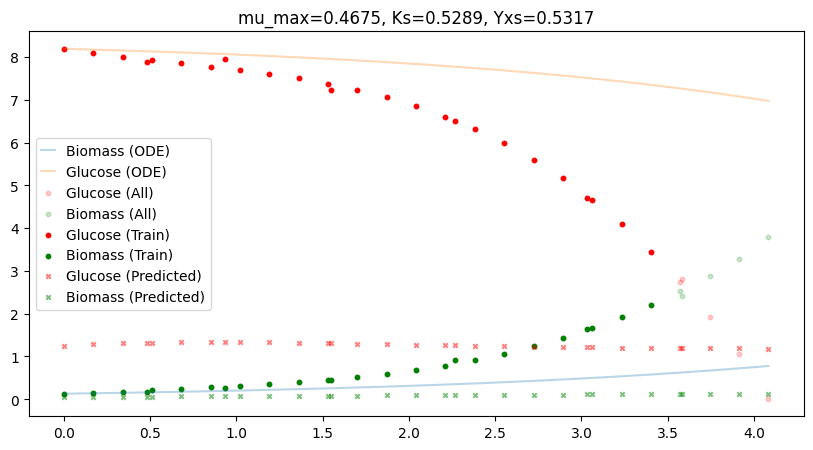

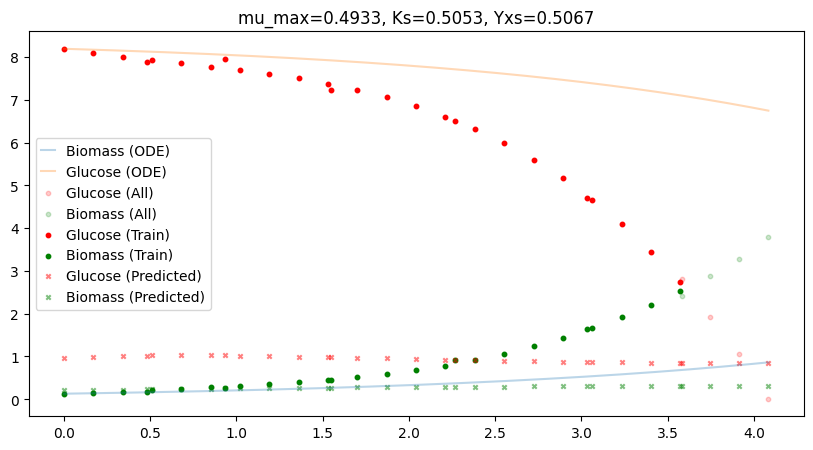

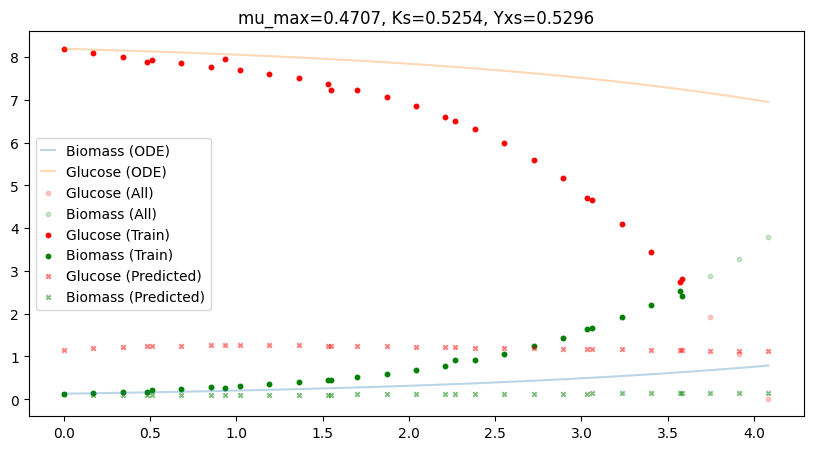

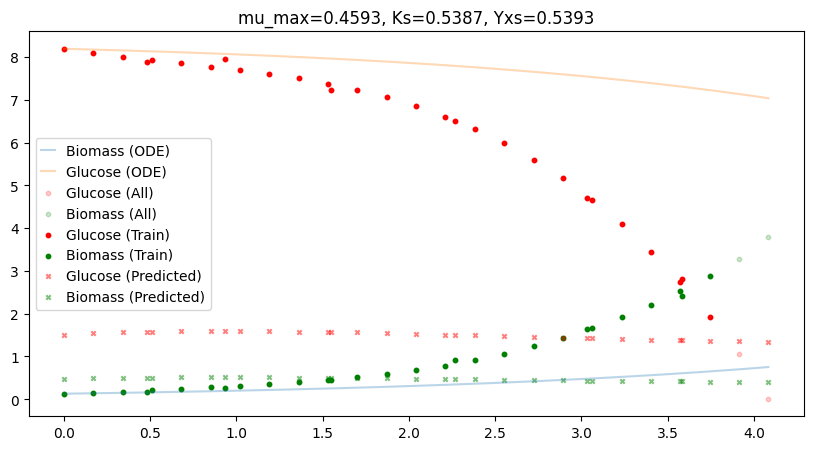

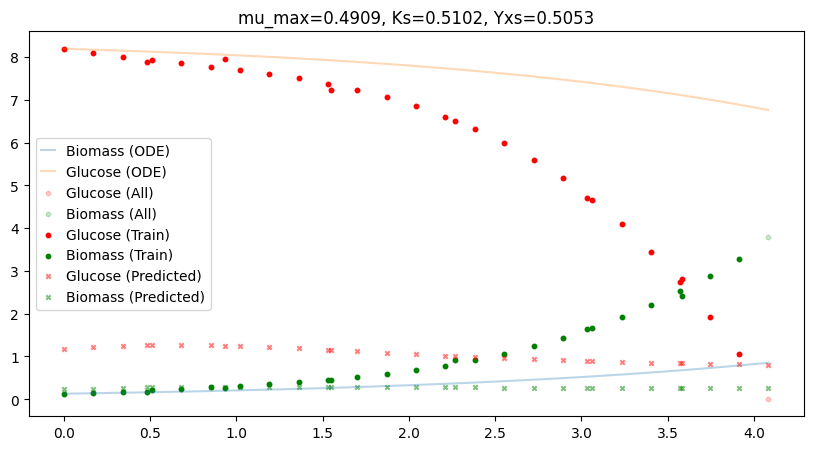

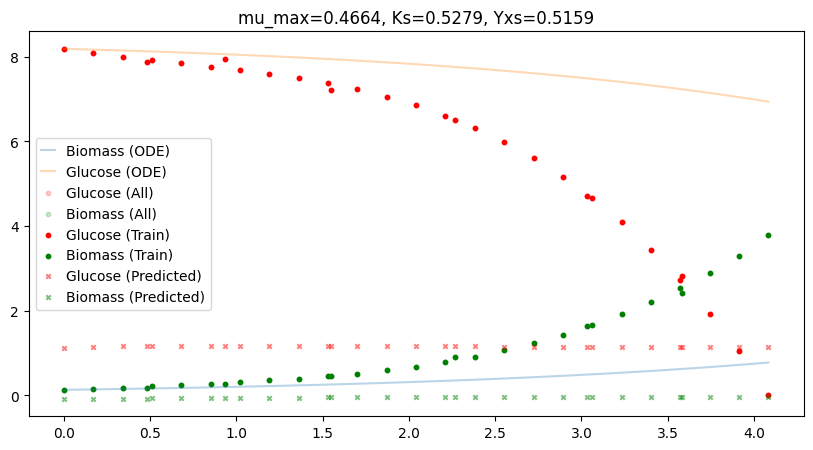

In [22]:
for i in range(2, len(df)+1):
    print(f'Training using {i} data points')
    
    _df = df.iloc[:i]
    t_start, t_end = _df['RTime'].min(), _df['RTime'].max()
    
    t = numpy_to_tensor(_df['RTime'].values)
    X = numpy_to_tensor(_df['Biomass'].values)
    S = numpy_to_tensor(_df['Glucose'].values)
    X_S = torch.cat((X, S), 1)
    
    # Define and Train PINN 
    net = PINN(1, 2, t_start=t_start, t_end=t_end)     
    net, total_loss, loss_data, loss_ic, loss_ode = train(net, t, X_S, df, num_epochs=10, verbose=True)

    # Store the results
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    net_df['RTime'] = t_test
    t_test = numpy_to_tensor(t_test)
    net_df['Biomass'] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df['Glucose'] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    
    print(f'mu_max: {mu_max:4f}, Ks: {Ks:4f}, Yxs: {Yxs:.4f}')
    
    solution = simulate(df, mu_max, Ks, Yxs)
    plot_simulation(solution.t, solution.y, df, _df, net_df, i, mu_max, Ks, Yxs)